# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Linear-Regression"><b>Analysis</b> - Linear-Regression</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
import os
import math
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Linear Regression

In [3]:
# Make sure the data is from all dates
df = pd.read_csv("../Neo4j_output/Centrality_Output.csv")
# Replace NaN with 0 to include developers who did not introduce any bugs
df['Number_of_Bugs'] = df['Number_of_Bugs'].fillna(0)
print(df)

                    Name   PageRank    Betweenness  Closeness  Harmonic  \
0             Seth Vargo  24.098295  172342.464826   0.917656  0.955134   
1     Mitchell Hashimoto  24.093374  263957.868091   0.879363  0.931406   
2          Chris Roberts  21.082051  177846.949345   0.842297  0.906385   
3               tfanning  19.974389   59072.500908   0.847842  0.910267   
4             Brian Cain  19.631400  131598.446530   0.818503  0.889129   
...                  ...        ...            ...        ...       ...   
1155               winky   0.153670       0.000000   0.487179  0.492091   
1156           Yufan Lou   0.153324       0.000000   0.459010  0.471096   
1157       Aidan Feldman   0.152928       0.000000   0.488000  0.492954   
1158        Steven Leung   0.152204       0.000000   0.498066  0.499569   
1159             Murathe   0.150903       0.000000   0.487795  0.492522   

        Degree  Number_of_Bugs  
0     108731.0           233.0  
1     786949.0           865.0  


#### Predictions with sklearn

In [4]:
linear_regressor = LinearRegression()

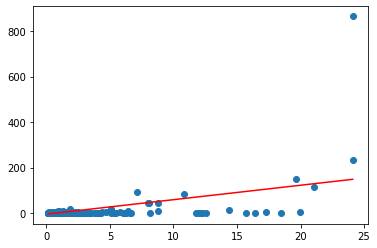

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     380.9
Date:                Mon, 30 May 2022   Prob (F-statistic):           1.47e-73
Time:                        17:24:55   Log-Likelihood:                -5312.7
No. Observations:                1160   AIC:                         1.063e+04
Df Residuals:                    1158   BIC:                         1.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4607      0.761     -5.859      0.0

In [5]:
x = df['PageRank'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [6]:
regression_results(y, y_pred)

explained_variance:  0.2475
r2:  0.2475
MAE:  4.8982
MSE:  556.645
RMSE:  23.5933


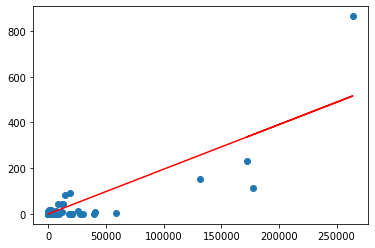

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2846.
Date:                Mon, 30 May 2022   Prob (F-statistic):          3.09e-314
Time:                        17:24:55   Log-Likelihood:                -4758.1
No. Observations:                1160   AIC:                             9520.
Df Residuals:                    1158   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      0.432     -1.120      0.2

In [7]:
x = df['Betweenness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [8]:
regression_results(y, y_pred)

explained_variance:  0.7108
r2:  0.7108
MAE:  2.1069
MSE:  213.94
RMSE:  14.6267


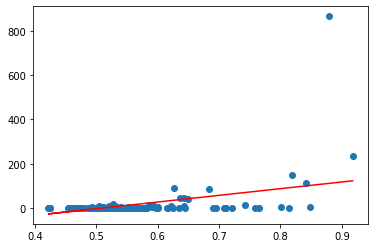

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     274.3
Date:                Mon, 30 May 2022   Prob (F-statistic):           1.84e-55
Time:                        17:24:55   Log-Likelihood:                -5354.3
No. Observations:                1160   AIC:                         1.071e+04
Df Residuals:                    1158   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -153.1468      9.375    -16.335      0.0

In [9]:
x = df['Closeness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [10]:
regression_results(y, y_pred)

explained_variance:  0.1915
r2:  0.1915
MAE:  5.8539
MSE:  598.0523
RMSE:  24.4551


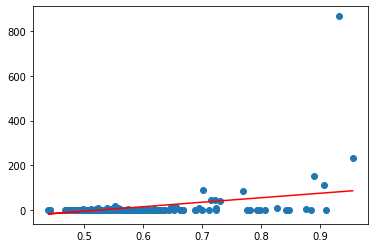

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     196.1
Date:                Mon, 30 May 2022   Prob (F-statistic):           2.85e-41
Time:                        17:24:56   Log-Likelihood:                -5386.9
No. Observations:                1160   AIC:                         1.078e+04
Df Residuals:                    1158   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.1860      7.597    -13.715      0.0

In [11]:
x = df['Harmonic'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [12]:
regression_results(y, y_pred)

explained_variance:  0.1448
r2:  0.1448
MAE:  5.983
MSE:  632.6194
RMSE:  25.1519


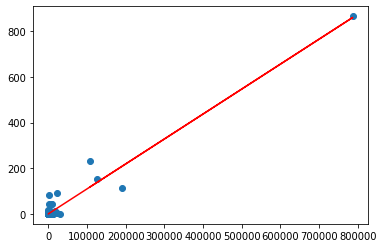

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 2.266e+04
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        17:24:56   Log-Likelihood:                -3724.0
No. Observations:                1160   AIC:                             7452.
Df Residuals:                    1158   BIC:                             7462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.177      1.078      0.2

In [13]:
x = df['Degree'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [14]:
regression_results(y, y_pred)

explained_variance:  0.9514
r2:  0.9514
MAE:  1.0246
MSE:  35.9721
RMSE:  5.9977


In [15]:
x = df[['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']]
y = df['Number_of_Bugs']
#model = linear_regressor.fit(x, y)
#y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         Number_of_Bugs   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4607.
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        17:24:56   Log-Likelihood:                -3712.9
No. Observations:                1160   AIC:                             7438.
Df Residuals:                    1154   BIC:                             7468.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.3917      7.621     -1.232      

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [16]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders

start = 0

if os.path.exists('out2.csv'):
    final_result_df = pd.read_csv('out2.csv', index_col=0)
    print(final_result_df)
    for index, row in final_result_df.iterrows():
        print()
        if math.isnan(row['XGB_precision_1']):
            break
        start += 1
else:
    final_result_df = pd.DataFrame({'XGB_precision_1':[None]*14, 
                                'XGB_precision_2':[None]*14,
                                'XGB_recall_1':[None]*14, 
                                'XGB_recall_2':[None]*14,
                                'XGB_f1_1':[None]*14, 
                                'XGB_f1_2':[None]*14,
                                'XGB_PRC_AUC_1':[None]*14,
                                'XGB_PRC_AUC_2':[None]*14,
                                'LR_precision_1':[None]*14, 
                                'LR_precision_2':[None]*14, 
                                'LR_recall_1':[None]*14, 
                                'LR_recall_2':[None]*14, 
                                'LR_f1_1':[None]*14, 
                                'LR_f1_2':[None]*14, 
                                'LR_PRC_AUC_1':[None]*14, 
                                'LR_PRC_AUC_2':[None]*14,
                                'RF_precision_1':[None]*14, 
                                'RF_precision_2':[None]*14,
                                'RF_recall_1':[None]*14, 
                                'RF_recall_2':[None]*14,
                                'RF_f1_1':[None]*14, 
                                'RF_f1_2':[None]*14,
                                'RF_PRC_AUC_1':[None]*14, 
                                'RF_PRC_AUC_2':[None]*14})

rankings = {'XGB':[], 'Logistic_Regression':[], 'Random_Forest':[]}

files = ['ActiveMQ', 'Ant', 'Camel', 'Derby', 'Geronimo', 'Hadoop', 'HBase', 'Ivy', 'JCR', 'JMeter', 'LOG4J2', 'Lucene', 'Mahout', 'OpenJPA']

for file_index in range(start, len(files)):
    graph_df = pd.read_csv(f"../Neo4j_output/Jit_Reliability_Output/{files[file_index]}.csv")
    print(graph_df.loc[graph_df['Bug'] == "INTRODUCED_NEW_BUG"])
    new_columns = {}

    # Generate binary classification for our dataframe based on if a developer 
    # introduced a bug or not with the corresponding commit
    for index in graph_df.index:
        if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
            graph_df.loc[index, "Bug"] = 0
        else:
            graph_df.loc[index, "Bug"] = 1

        # separate each node2vec embedding into it's own unique label
        embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
        for i, embedding in enumerate(embeddings):
            if f"emb_{i}" not in new_columns:
                new_columns[f"emb_{i}"] = []
                new_columns[f"emb_{i}"].append(embedding)
            else:
                new_columns[f"emb_{i}"].append(embedding)

    # delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
    del graph_df['n2vEmbedding']
    temp_df = pd.DataFrame.from_dict(new_columns)
    graph_df = graph_df.join(temp_df)
    
    x = graph_df["Name"]
    y = graph_df["Bug"].astype('int')

    lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
    lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
    rf_model1 = RandomForestClassifier(n_estimators=120)
    rf_model2 = RandomForestClassifier(n_estimators=120)
    xgb_model1 = XGBClassifier(verbosity = 0)
    xgb_model2 = XGBClassifier(verbosity = 0)

    '''
    train_test_split params
    -----------------------
    graph_df: Graph dataset
    test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
    random_state = used to create reproducible, or deterministic results.
    '''
    try:
        train, test = train_test_split(graph_df, test_size=0.30, random_state = 5)
    except:
        continue
    train = train.reset_index()
    test = test.reset_index()

    # Labels used for model 1
    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

    # Labels used for model 2
    labels2 = set(list(graph_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"]
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"]
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    results_data = [[None for j in range(15)] for i in range(72)]

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    print("Original_Logistic_Regression model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[0][0] = "Original_Logistic_Regression"
    results_data[0][1] = lr_model1.score(x1_test, y_test)
    results_data[0][2] = lr_model2.score(x2_test, y_test)
    results_data[0][3] = acc1
    results_data[0][4] = acc2
    results_data[0][5] = prc_val1
    results_data[0][6] = prc_val2
    results_data[0][7] = pr_auc1
    results_data[0][8] = pr_auc2
    results_data[0][9] = prec_1
    results_data[0][10] = prec_2
    results_data[0][11] = rec_1
    results_data[0][12] = rec_2
    results_data[0][13] = f1_1
    results_data[0][14] = f1_2

    print("Original_Random_Forrest model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[1][0] = "Original_Random_Forrest"
    results_data[1][1] = rf_model1.score(x1_test, y_test)
    results_data[1][2] = rf_model2.score(x2_test, y_test)
    results_data[1][3] = acc1
    results_data[1][4] = acc2
    results_data[1][5] = prc_val1
    results_data[1][6] = prc_val2
    results_data[1][7] = pr_auc1
    results_data[1][8] = pr_auc2
    results_data[1][9] = prec_1
    results_data[1][10] = prec_2
    results_data[1][11] = rec_1
    results_data[1][12] = rec_2
    results_data[1][13] = f1_1
    results_data[1][14] = f1_2

    print("Original_XGB model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[2][0] = "Original_XGB_Classifier"
    results_data[2][1] = xgb_model1.score(x1_test, y_test)
    results_data[2][2] = xgb_model2.score(x2_test, y_test)
    results_data[2][3] = acc1
    results_data[2][4] = acc2
    results_data[2][5] = prc_val1
    results_data[2][6] = prc_val2
    results_data[2][7] = pr_auc1
    results_data[2][8] = pr_auc2
    results_data[2][9] = prec_1
    results_data[2][10] = prec_2
    results_data[2][11] = rec_1
    results_data[2][12] = rec_2
    results_data[2][13] = f1_1
    results_data[2][14] = f1_2

    lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")
    rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")
    xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    print("Original_Logistic_Regression_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

    results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
    results_data[3][1] = lr_model1.score(x1_test, y_test)
    results_data[3][2] = lr_model2.score(x2_test, y_test)
    results_data[3][3] = acc1
    results_data[3][4] = acc2
    results_data[3][5] = prc_val1
    results_data[3][6] = prc_val2
    results_data[3][7] = pr_auc1
    results_data[3][8] = pr_auc2
    results_data[3][9] = prec_1
    results_data[3][10] = prec_2
    results_data[3][11] = rec_1
    results_data[3][12] = rec_2
    results_data[3][13] = f1_1
    results_data[3][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    print("Original_Random_Forrest_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    
    results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
    results_data[4][1] = rf_model1.score(x1_test, y_test)
    results_data[4][2] = rf_model2.score(x2_test, y_test)
    results_data[4][3] = acc1
    results_data[4][4] = acc2
    results_data[4][5] = prc_val1
    results_data[4][6] = prc_val2
    results_data[4][7] = pr_auc1
    results_data[4][8] = pr_auc2
    results_data[4][9] = prec_1
    results_data[4][10] = prec_2
    results_data[4][11] = rec_1
    results_data[4][12] = rec_2
    results_data[4][13] = f1_1
    results_data[4][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    
    results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
    results_data[5][1] = xgb_model1.score(x1_test, y_test)
    results_data[5][2] = xgb_model2.score(x2_test, y_test)
    results_data[5][3] = acc1
    results_data[5][4] = acc2
    results_data[5][5] = prc_val1
    results_data[5][6] = prc_val2
    results_data[5][7] = pr_auc1
    results_data[5][8] = pr_auc2
    results_data[5][9] = prec_1
    results_data[5][10] = prec_2
    results_data[5][11] = rec_1
    results_data[5][12] = rec_2
    results_data[5][13] = f1_1
    results_data[5][14] = f1_2

    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df['Bug'].astype('int')

    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y)
    
    results_data[6][0] = "Original_Logistic_Regression_rkf"
    results_data[6][1] = model_score
    results_data[6][3] = acc
    results_data[6][5] = prc_val
    results_data[6][7] = pr_auc
    results_data[6][9] = precision
    results_data[6][11] = recall
    results_data[6][13] = f1
    print("---------------------")
    print("With best threshold")
    
    print("Original_Logistic_Regression_rkf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
    results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
    results_data[7][1] = model_score
    results_data[7][3] = acc
    results_data[7][5] = prc_val
    results_data[7][7] = pr_auc
    results_data[7][9] = precision
    results_data[7][11] = recall
    results_data[7][13] = f1

    # Rkf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_rkf model 1")
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, x1, y)
    results_data[8][0] = "Original_Random_Forrest_rkf"
    results_data[8][1] = model_score
    results_data[8][3] = acc
    results_data[8][5] = prc_val
    results_data[8][7] = pr_auc
    results_data[8][9] = precision
    results_data[8][11] = recall
    results_data[8][13] = f1

    print("Original_XGB_Classifier_rkf model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, x1, y)
    results_data[9][0] = "Original_XGB_Classifier_rkf"
    results_data[9][1] = model_score
    results_data[9][3] = acc
    results_data[9][5] = prc_val
    results_data[9][7] = pr_auc
    results_data[9][9] = precision
    results_data[9][11] = recall
    results_data[9][13] = f1

    print("Original_Logistic_Regression_skf model 1")
    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y)
    results_data[10][0] = "Original_Logistic_Regression_skf"
    results_data[10][1] = model_score
    results_data[10][3] = acc
    results_data[10][5] = prc_val
    results_data[10][7] = pr_auc
    results_data[10][9] = precision
    results_data[10][11] = recall
    results_data[10][13] = f1

    print("Original_Logistic_Regression_skf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y, lr_best_threshold1)
    results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
    results_data[11][1] = model_score
    results_data[11][3] = acc
    results_data[11][5] = prc_val
    results_data[11][7] = pr_auc
    results_data[11][9] = precision
    results_data[11][11] = recall
    results_data[11][13] = f1

    print("Original_Random_Forrest_skf model 1")
    # Skf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, x1, y)
    results_data[12][0] = "Original_Random_Forrest_skf"
    results_data[12][1] = model_score
    results_data[12][3] = acc
    results_data[12][5] = prc_val
    results_data[12][7] = pr_auc
    results_data[12][9] = precision
    results_data[12][11] = recall
    results_data[12][13] = f1

    print("Original_XGB_Classifier_skf model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, x1, y)
    results_data[13][0] = "Original_XGB_Classifier_skf"
    results_data[13][1] = model_score
    results_data[13][3] = acc
    results_data[13][5] = prc_val
    results_data[13][7] = pr_auc
    results_data[13][9] = precision
    results_data[13][11] = recall
    results_data[13][13] = f1

    print("Original_Logistic_Regression_tss model 1")
    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y)
    results_data[14][0] = "Original_Logistic_Regression_tss"
    results_data[14][1] = model_score
    results_data[14][3] = acc
    results_data[14][5] = prc_val
    results_data[14][7] = pr_auc
    results_data[14][9] = precision
    results_data[14][11] = recall
    results_data[14][13] = f1

    print("Original_Logistic_Regression_tss_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y, lr_best_threshold1)
    results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
    results_data[15][1] = model_score
    results_data[15][3] = acc
    results_data[15][5] = prc_val
    results_data[15][7] = pr_auc
    results_data[15][9] = precision
    results_data[15][11] = recall
    results_data[15][13] = f1

    # Skf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_tss model 1")
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, x1, y)
    results_data[16][0] = "Original_Random_Forrest_tss"
    results_data[16][1] = model_score
    results_data[16][3] = acc
    results_data[16][5] = prc_val
    results_data[16][7] = pr_auc
    results_data[16][9] = precision
    results_data[16][11] = recall
    results_data[16][13] = f1

    print("Original_XGB_Classifier_tss model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, x1, y)
    results_data[17][0] = "Original_XGB_Classifier_tss"
    results_data[17][1] = model_score
    results_data[17][3] = acc
    results_data[17][5] = prc_val
    results_data[17][7] = pr_auc
    results_data[17][9] = precision
    results_data[17][11] = recall
    results_data[17][13] = f1

    # ---- Data for Model 2 ----
    print("Row 6 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y)
    results_data[6][2] = model_score
    results_data[6][4] = acc
    results_data[6][6] = prc_val
    results_data[6][8] = pr_auc
    results_data[6][10] = precision
    results_data[6][12] = recall
    results_data[6][14] = f1

    print("Row 7 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y, lr_best_threshold2)
    results_data[7][2] = model_score
    results_data[7][4] = acc
    results_data[7][6] = prc_val
    results_data[7][8] = pr_auc
    results_data[7][10] = precision
    results_data[7][12] = recall
    results_data[7][14] = f1

    # Rkf_short(lr_model2, x2, y)

    print("Row 8 model 2")
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, x2, y)
    results_data[8][2] = model_score
    results_data[8][4] = acc
    results_data[8][6] = prc_val
    results_data[8][8] = pr_auc
    results_data[8][10] = precision
    results_data[8][12] = recall
    results_data[8][14] = f1

    print("Row 9 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, x2, y)
    results_data[9][2] = model_score
    results_data[9][4] = acc
    results_data[9][6] = prc_val
    results_data[9][8] = pr_auc
    results_data[9][10] = precision
    results_data[9][12] = recall
    results_data[9][14] = f1

    print("Row 10 model 2")
    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y)
    results_data[10][2] = model_score
    results_data[10][4] = acc
    results_data[10][6] = prc_val
    results_data[10][8] = pr_auc
    results_data[10][10] = precision
    results_data[10][12] = recall
    results_data[10][14] = f1

    print("Row 11 model 2")
    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y, lr_best_threshold2)
    results_data[11][2] = model_score
    results_data[11][4] = acc
    results_data[11][6] = prc_val
    results_data[11][8] = pr_auc
    results_data[11][10] = precision
    results_data[11][12] = recall
    results_data[11][14] = f1

    print("Row 12 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, x2, y)
    results_data[12][2] = model_score
    results_data[12][4] = acc
    results_data[12][6] = prc_val
    results_data[12][8] = pr_auc
    results_data[12][10] = precision
    results_data[12][12] = recall
    results_data[12][14] = f1

    print("Row 13 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, x2, y)
    results_data[13][2] = model_score
    results_data[13][4] = acc
    results_data[13][6] = prc_val
    results_data[13][8] = pr_auc
    results_data[13][10] = precision
    results_data[13][12] = recall
    results_data[13][14] = f1

    print("Row 14 model 2")
    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y)
    results_data[14][2] = model_score
    results_data[14][4] = acc
    results_data[14][6] = prc_val
    results_data[14][8] = pr_auc
    results_data[14][10] = precision
    results_data[14][12] = recall
    results_data[14][14] = f1

    print("Row 15 model 2")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y, lr_best_threshold2)
    results_data[15][2] = model_score
    results_data[15][4] = acc
    results_data[15][6] = prc_val
    results_data[15][8] = pr_auc
    results_data[15][10] = precision
    results_data[15][12] = recall
    results_data[15][14] = f1

    print("Row 16 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, x2, y)
    results_data[16][2] = model_score
    results_data[16][4] = acc
    results_data[16][6] = prc_val
    results_data[16][8] = pr_auc
    results_data[16][10] = precision
    results_data[16][12] = recall
    results_data[16][14] = f1

    print("Row 17 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, x2, y)
    results_data[17][2] = model_score
    results_data[17][4] = acc
    results_data[17][6] = prc_val
    results_data[17][8] = pr_auc
    results_data[17][10] = precision
    results_data[17][12] = recall
    results_data[17][14] = f1

    lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
    rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
    xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

    lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
    rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
    xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

    lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
    rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
    xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

    # Perform undersampling
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    
    bug_df = graph_df.loc[graph_df['Bug'] == 1]
    non_bug_df = graph_df.loc[graph_df['Bug'] == 0]
    normalized_under_df = pd.concat([bug_df, non_bug_df])
    normalized_under_df = normalized_under_df.reset_index()
    print(normalized_under_df['Bug'].value_counts())

    usx1 = normalized_under_df[labels1]
    usx2 = normalized_under_df[labels2]
    usy = normalized_under_df["Bug"].astype('int')
    usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset
    usy1 = usy
    usy2 = usy
    
    usx1, usy1 = rus.fit_resample(usx1, usy1)
    usx2, usy2 = rus.fit_resample(usx2, usy2)

    train, test = train_test_split(normalized_under_df, test_size=0.30, random_state = 5)

    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
    labels2 = set(list(normalized_under_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"].astype('int')
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"].astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[18][0] = "Undersampled_Logistic_Regression"
    results_data[18][1] = lr_model1.score(x1_test, y_test)
    results_data[18][2] = lr_model2.score(x2_test, y_test)

    results_data[19][0] = "Undersampled_Random_Forrest"
    results_data[19][1] = rf_model1.score(x1_test, y_test)
    results_data[19][2] = rf_model2.score(x2_test, y_test)

    results_data[20][0] = "Undersampled_XGB_Classifier"
    results_data[20][1] = xgb_model1.score(x1_test, y_test)
    results_data[20][2] = xgb_model2.score(x2_test, y_test)

    print("Row 18 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[18][3] = acc1
    results_data[18][4] = acc2
    results_data[18][5] = prc_val1
    results_data[18][6] = prc_val2
    results_data[18][7] = pr_auc1
    results_data[18][8] = pr_auc2
    results_data[18][9] = prec_1
    results_data[18][10] = prec_2
    results_data[18][11] = rec_1
    results_data[18][12] = rec_2
    results_data[18][13] = f1_1
    results_data[18][14] = f1_2

    print("Row 19 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[19][3] = acc1
    results_data[19][4] = acc2
    results_data[19][5] = prc_val1
    results_data[19][6] = prc_val2
    results_data[19][7] = pr_auc1
    results_data[19][8] = pr_auc2
    results_data[19][9] = prec_1
    results_data[19][10] = prec_2
    results_data[19][11] = rec_1
    results_data[19][12] = rec_2
    results_data[19][13] = f1_1
    results_data[19][14] = f1_2

    print("Row 20 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[20][3] = acc1
    results_data[20][4] = acc2
    results_data[20][5] = prc_val1
    results_data[20][6] = prc_val2
    results_data[20][7] = pr_auc1
    results_data[20][8] = pr_auc2
    results_data[20][9] = prec_1
    results_data[20][10] = prec_2
    results_data[20][11] = rec_1
    results_data[20][12] = rec_2
    results_data[20][13] = f1_1
    results_data[20][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
    results_data[21][1] = lr_model1.score(x1_test, y_test)
    results_data[21][2] = lr_model2.score(x2_test, y_test)
    results_data[21][3] = acc1
    results_data[21][4] = acc2
    results_data[21][5] = prc_val1
    results_data[21][6] = prc_val2
    results_data[21][7] = pr_auc1
    results_data[21][8] = pr_auc2
    results_data[21][9] = prec_1
    results_data[21][10] = prec_2
    results_data[21][11] = rec_1
    results_data[21][12] = rec_2
    results_data[21][13] = f1_1
    results_data[21][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
    results_data[22][1] = rf_model1.score(x1_test, y_test)
    results_data[22][2] = rf_model2.score(x2_test, y_test)
    results_data[22][3] = acc1
    results_data[22][4] = acc2
    results_data[22][5] = prc_val1
    results_data[22][6] = prc_val2
    results_data[22][7] = pr_auc1
    results_data[22][8] = pr_auc2
    results_data[22][9] = prec_1
    results_data[22][10] = prec_2
    results_data[22][11] = rec_1
    results_data[22][12] = rec_2
    results_data[22][13] = f1_1
    results_data[22][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 23 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
    results_data[23][1] = xgb_model1.score(x1_test, y_test)
    results_data[23][2] = xgb_model2.score(x2_test, y_test)
    results_data[23][3] = acc1
    results_data[23][4] = acc2
    results_data[23][5] = prc_val1
    results_data[23][6] = prc_val2
    results_data[23][7] = pr_auc1
    results_data[23][8] = pr_auc2
    results_data[23][9] = prec_1
    results_data[23][10] = prec_2
    results_data[23][11] = rec_1
    results_data[23][12] = rec_2
    results_data[23][13] = f1_1
    results_data[23][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy1)
    results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
    results_data[24][1] = model_score
    results_data[24][3] = acc
    results_data[24][5] = prc_val
    results_data[24][7] = pr_auc
    results_data[24][9] = precision
    results_data[24][11] = recall
    results_data[24][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[25][1] = model_score
    results_data[25][3] = acc
    results_data[25][5] = prc_val
    results_data[25][7] = pr_auc
    results_data[25][9] = precision
    results_data[25][11] = recall
    results_data[25][13] = f1

    #Rkf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, usx1, usy1)
    results_data[26][0] = "Undersampled_Random_Forrest_rkf"
    results_data[26][1] = model_score
    results_data[26][3] = acc
    results_data[26][5] = prc_val
    results_data[26][7] = pr_auc
    results_data[26][9] = precision
    results_data[26][11] = recall
    results_data[26][13] = f1

    print("Row 27 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, usx1, usy1)
    results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
    results_data[27][1] = model_score
    results_data[27][3] = acc
    results_data[27][5] = prc_val
    results_data[27][7] = pr_auc
    results_data[27][9] = precision
    results_data[27][11] = recall
    results_data[27][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy1)
    results_data[28][0] = "Undersampled_Logistic_Regression_skf"
    results_data[28][1] = model_score
    results_data[28][3] = acc
    results_data[28][5] = prc_val
    results_data[28][7] = pr_auc
    results_data[28][9] = precision
    results_data[28][11] = recall
    results_data[28][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
    results_data[29][1] = model_score
    results_data[29][3] = acc
    results_data[29][5] = prc_val
    results_data[29][7] = pr_auc
    results_data[29][9] = precision
    results_data[29][11] = recall
    results_data[29][13] = f1

    # Skf_short(lr_model1, usx1, usy)

    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, usx1, usy1)
    results_data[30][0] = "Undersampled_Random_Forrest_skf"
    results_data[30][1] = model_score
    results_data[30][3] = acc
    results_data[30][5] = prc_val
    results_data[30][7] = pr_auc
    results_data[30][9] = precision
    results_data[30][11] = recall
    results_data[30][13] = f1

    print("Row 31 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, usx1, usy1)
    results_data[31][0] = "Undersampled_XGB_Classifier_skf"
    results_data[31][1] = model_score
    results_data[31][3] = acc
    results_data[31][5] = prc_val
    results_data[31][7] = pr_auc
    results_data[31][9] = precision
    results_data[31][11] = recall
    results_data[31][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy1)
    results_data[32][0] = "Undersampled_Logistic_Regression_tss"
    results_data[32][1] = model_score
    results_data[32][3] = acc
    results_data[32][5] = prc_val
    results_data[32][7] = pr_auc
    results_data[32][9] = precision
    results_data[32][11] = recall
    results_data[32][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
    results_data[33][1] = model_score
    results_data[33][3] = acc
    results_data[33][5] = prc_val
    results_data[33][7] = pr_auc
    results_data[33][9] = precision
    results_data[33][11] = recall
    results_data[33][13] = f1

    # Skf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, usx1, usy1)
    results_data[34][0] = "Undersampled_Random_Forrest_tss"
    results_data[34][1] = model_score
    results_data[34][3] = acc
    results_data[34][5] = prc_val
    results_data[34][7] = pr_auc
    results_data[34][9] = precision
    results_data[34][11] = recall
    results_data[34][13] = f1

    print("Row 35 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, usx1, usy1)
    results_data[35][0] = "Undersampled_XGB_Classifier_tss"
    results_data[35][1] = model_score
    results_data[35][3] = acc
    results_data[35][5] = prc_val
    results_data[35][7] = pr_auc
    results_data[35][9] = precision
    results_data[35][11] = recall
    results_data[35][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy2)
    results_data[24][2] = model_score
    results_data[24][4] = acc
    results_data[24][6] = prc_val
    results_data[24][8] = pr_auc
    results_data[24][10] = precision
    results_data[24][12] = recall
    results_data[24][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[25][2] = model_score
    results_data[25][4] = acc
    results_data[25][6] = prc_val
    results_data[25][8] = pr_auc
    results_data[25][10] = precision
    results_data[25][12] = recall
    results_data[25][14] = f1

    # Rkf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, usx2, usy2)
    results_data[26][2] = model_score
    results_data[26][4] = acc
    results_data[26][6] = prc_val
    results_data[26][8] = pr_auc
    results_data[26][10] = precision
    results_data[26][12] = recall
    results_data[26][14] = f1

    print("Row 27 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, usx2, usy2)
    results_data[27][2] = model_score
    results_data[27][4] = acc
    results_data[27][6] = prc_val
    results_data[27][8] = pr_auc
    results_data[27][10] = precision
    results_data[27][12] = recall
    results_data[27][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy2)
    results_data[28][2] = model_score
    results_data[28][4] = acc
    results_data[28][6] = prc_val
    results_data[28][8] = pr_auc
    results_data[28][10] = precision
    results_data[28][12] = recall
    results_data[28][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[29][2] = model_score
    results_data[29][4] = acc
    results_data[29][6] = prc_val
    results_data[29][8] = pr_auc
    results_data[29][10] = precision
    results_data[29][12] = recall
    results_data[29][14] = f1

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, usx2, usy2)
    results_data[30][2] = model_score
    results_data[30][4] = acc
    results_data[30][6] = prc_val
    results_data[30][8] = pr_auc
    results_data[30][10] = precision
    results_data[30][12] = recall
    results_data[30][14] = f1

    print("Row 31 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, usx2, usy2)
    results_data[31][2] = model_score
    results_data[31][4] = acc
    results_data[31][6] = prc_val
    results_data[31][8] = pr_auc
    results_data[31][10] = precision
    results_data[31][12] = recall
    results_data[31][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy)
    results_data[32][2] = model_score
    results_data[32][4] = acc
    results_data[32][6] = prc_val
    results_data[32][8] = pr_auc
    results_data[32][10] = precision
    results_data[32][12] = recall
    results_data[32][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[33][2] = model_score
    results_data[33][4] = acc
    results_data[33][6] = prc_val
    results_data[33][8] = pr_auc
    results_data[33][10] = precision
    results_data[33][12] = recall
    results_data[33][14] = f1

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, usx2, usy2)
    results_data[34][2] = model_score
    results_data[34][4] = acc
    results_data[34][6] = prc_val
    results_data[34][8] = pr_auc
    results_data[34][10] = precision
    results_data[34][12] = recall
    results_data[34][14] = f1

    print("Row 35 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, usx2, usy2)
    results_data[35][2] = model_score
    results_data[35][4] = acc
    results_data[35][6] = prc_val
    results_data[35][8] = pr_auc
    results_data[35][10] = precision
    results_data[35][12] = recall
    results_data[35][14] = f1

    # Oversampling
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')
    # For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[36][0] = "Oversampled_Logistic_Regression"
    results_data[36][1] = lr_model1.score(x1_test, y1_test)
    results_data[36][2] = lr_model2.score(x2_test, y2_test)

    results_data[37][0] = "Oversampled_Random_Forrest"
    results_data[37][1] = rf_model1.score(x1_test, y1_test)
    results_data[37][2] = rf_model2.score(x2_test, y2_test)

    results_data[38][0] = "Oversampled_XGB_Classifier"
    results_data[38][1] = xgb_model1.score(x1_test, y1_test)
    results_data[38][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[36][3] = acc1
    results_data[36][4] = acc2
    results_data[36][5] = prc_val1
    results_data[36][6] = prc_val2
    results_data[36][7] = pr_auc1
    results_data[36][8] = pr_auc2
    results_data[36][9] = prec_1
    results_data[36][10] = prec_2
    results_data[36][11] = rec_1
    results_data[36][12] = rec_2
    results_data[36][13] = f1_1
    results_data[36][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[37][3] = acc1
    results_data[37][4] = acc2
    results_data[37][5] = prc_val1
    results_data[37][6] = prc_val2
    results_data[37][7] = pr_auc1
    results_data[37][8] = pr_auc2
    results_data[37][9] = prec_1
    results_data[37][10] = prec_2
    results_data[37][11] = rec_1
    results_data[37][12] = rec_2
    results_data[37][13] = f1_1
    results_data[37][14] = f1_2

    print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
    print("Row 38 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[38][3] = acc1
    results_data[38][4] = acc2
    results_data[38][5] = prc_val1
    results_data[38][6] = prc_val2
    results_data[38][7] = pr_auc1
    results_data[38][8] = pr_auc2
    results_data[38][9] = prec_1
    results_data[38][10] = prec_2
    results_data[38][11] = rec_1
    results_data[38][12] = rec_2
    results_data[38][13] = f1_1
    results_data[38][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[39][1] = lr_model1.score(x1_test, y1_test)
    results_data[39][2] = lr_model2.score(x2_test, y2_test)
    results_data[39][3] = acc1
    results_data[39][4] = acc2
    results_data[39][5] = prc_val1
    results_data[39][6] = prc_val2
    results_data[39][7] = pr_auc1
    results_data[39][8] = pr_auc2
    results_data[39][9] = prec_1
    results_data[39][10] = prec_2
    results_data[39][11] = rec_1
    results_data[39][12] = rec_2
    results_data[39][13] = f1_1
    results_data[39][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[40][1] = rf_model1.score(x1_test, y1_test)
    results_data[40][2] = rf_model2.score(x2_test, y2_test)
    results_data[40][3] = acc1
    results_data[40][4] = acc2
    results_data[40][5] = prc_val1
    results_data[40][6] = prc_val2
    results_data[40][7] = pr_auc1
    results_data[40][8] = pr_auc2
    results_data[40][9] = prec_1
    results_data[40][10] = prec_2
    results_data[40][11] = rec_1
    results_data[40][12] = rec_2
    results_data[40][13] = f1_1
    results_data[40][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[41][1] = xgb_model1.score(x1_test, y1_test)
    results_data[41][2] = xgb_model2.score(x2_test, y2_test)
    results_data[41][3] = acc1
    results_data[41][4] = acc2
    results_data[41][5] = prc_val1
    results_data[41][6] = prc_val2
    results_data[41][7] = pr_auc1
    results_data[41][8] = pr_auc2
    results_data[41][9] = prec_1
    results_data[41][10] = prec_2
    results_data[41][11] = rec_1
    results_data[41][12] = rec_2
    results_data[41][13] = f1_1
    results_data[41][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1)
    results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
    results_data[42][1] = model_score
    results_data[42][3] = acc
    results_data[42][5] = prc_val
    results_data[42][7] = pr_auc
    results_data[42][9] = precision
    results_data[42][11] = recall
    results_data[42][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[43][1] = model_score
    results_data[43][3] = acc
    results_data[43][5] = prc_val
    results_data[43][7] = pr_auc
    results_data[43][9] = precision
    results_data[43][11] = recall
    results_data[43][13] = f1

    # Rkf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, osx1, osy1)
    results_data[44][0] = "Oversampled_Random_Forrest_rkf"
    results_data[44][1] = model_score
    results_data[44][3] = acc
    results_data[44][5] = prc_val
    results_data[44][7] = pr_auc
    results_data[44][9] = precision
    results_data[44][11] = recall
    results_data[44][13] = f1

    print("Row 45 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, osx1, osy1)
    results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
    results_data[45][1] = model_score
    results_data[45][3] = acc
    results_data[45][5] = prc_val
    results_data[45][7] = pr_auc
    results_data[45][9] = precision
    results_data[45][11] = recall
    results_data[45][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1)
    results_data[46][0] = "Oversampled_Logistic_Regression_skf"
    results_data[46][1] = model_score
    results_data[46][3] = acc
    results_data[46][5] = prc_val
    results_data[46][7] = pr_auc
    results_data[46][9] = precision
    results_data[46][11] = recall
    results_data[46][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
    results_data[47][1] = model_score
    results_data[47][3] = acc
    results_data[47][5] = prc_val
    results_data[47][7] = pr_auc
    results_data[47][9] = precision
    results_data[47][11] = recall
    results_data[47][13] = f1

    # Skf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, osx1, osy1)
    results_data[48][0] = "Oversampled_Random_Forrest_skf"
    results_data[48][1] = model_score
    results_data[48][3] = acc
    results_data[48][5] = prc_val
    results_data[48][7] = pr_auc
    results_data[48][9] = precision
    results_data[48][11] = recall
    results_data[48][13] = f1

    print("Row 49 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][0] = "Oversampled_XGB_Classifier_skf"
    results_data[49][1] = model_score
    results_data[49][3] = acc
    results_data[49][5] = prc_val
    results_data[49][7] = pr_auc
    results_data[49][9] = precision
    results_data[49][11] = recall
    results_data[49][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1)
    results_data[50][0] = "Oversampled_Logistic_Regression_tss"
    results_data[50][1] = model_score
    results_data[50][3] = acc
    results_data[50][5] = prc_val
    results_data[50][7] = pr_auc
    results_data[50][9] = precision
    results_data[50][11] = recall
    results_data[50][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
    results_data[51][1] = model_score
    results_data[51][3] = acc
    results_data[51][5] = prc_val
    results_data[51][7] = pr_auc
    results_data[51][9] = precision
    results_data[51][11] = recall
    results_data[51][13] = f1

    # Tss_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, osx1, osy1)
    results_data[52][0] = "Oversampled_Random_Forrest_tss"
    results_data[52][1] = model_score
    results_data[52][3] = acc
    results_data[52][5] = prc_val
    results_data[52][7] = pr_auc
    results_data[52][9] = precision
    results_data[52][11] = recall
    results_data[52][13] = f1

    print("Row 53 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, osx1, osy1)
    results_data[53][0] = "Oversampled_XGB_Classifier_tss"
    results_data[53][1] = model_score
    results_data[53][3] = acc
    results_data[53][5] = prc_val
    results_data[53][7] = pr_auc
    results_data[53][9] = precision
    results_data[53][11] = recall
    results_data[53][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2)
    results_data[42][2] = model_score
    results_data[42][4] = acc
    results_data[42][6] = prc_val
    results_data[42][8] = pr_auc
    results_data[42][10] = precision
    results_data[42][12] = recall
    results_data[42][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[43][2] = model_score
    results_data[43][4] = acc
    results_data[43][6] = prc_val
    results_data[43][8] = pr_auc
    results_data[43][10] = precision
    results_data[43][12] = recall
    results_data[43][14] = f1

    # Rkf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, osx2, osy2)
    results_data[44][2] = model_score
    results_data[44][4] = acc
    results_data[44][6] = prc_val
    results_data[44][8] = pr_auc
    results_data[44][10] = precision
    results_data[44][12] = recall
    results_data[44][14] = f1

    print("Row 45 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, osx2, osy2)
    results_data[45][2] = model_score
    results_data[45][4] = acc
    results_data[45][6] = prc_val
    results_data[45][8] = pr_auc
    results_data[45][10] = precision
    results_data[45][12] = recall
    results_data[45][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2)
    results_data[46][2] = model_score
    results_data[46][4] = acc
    results_data[46][6] = prc_val
    results_data[46][8] = pr_auc
    results_data[46][10] = precision
    results_data[46][12] = recall
    results_data[46][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[47][2] = model_score
    results_data[47][4] = acc
    results_data[47][6] = prc_val
    results_data[47][8] = pr_auc
    results_data[47][10] = precision
    results_data[47][12] = recall
    results_data[47][14] = f1

    # Skf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, osx2, osy2)
    results_data[48][2] = model_score
    results_data[48][4] = acc
    results_data[48][6] = prc_val
    results_data[48][8] = pr_auc
    results_data[48][10] = precision
    results_data[48][12] = recall
    results_data[48][14] = f1

    print("Row 49 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][2] = model_score
    results_data[49][4] = acc
    results_data[49][6] = prc_val
    results_data[49][8] = pr_auc
    results_data[49][10] = precision
    results_data[49][12] = recall
    results_data[49][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2)
    results_data[50][2] = model_score
    results_data[50][4] = acc
    results_data[50][6] = prc_val
    results_data[50][8] = pr_auc
    results_data[50][10] = precision
    results_data[50][12] = recall
    results_data[50][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[51][2] = model_score
    results_data[51][4] = acc
    results_data[51][6] = prc_val
    results_data[51][8] = pr_auc
    results_data[51][10] = precision
    results_data[51][12] = recall
    results_data[51][14] = f1

    # Tss_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, osx2, osy2)
    results_data[52][2] = model_score
    results_data[52][4] = acc
    results_data[52][6] = prc_val
    results_data[52][8] = pr_auc
    results_data[52][10] = precision
    results_data[52][12] = recall
    results_data[52][14] = f1

    print("Row 53 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, osx2, osy2)
    results_data[53][2] = model_score
    results_data[53][4] = acc
    results_data[53][6] = prc_val
    results_data[53][8] = pr_auc
    results_data[53][10] = precision
    results_data[53][12] = recall
    results_data[53][14] = f1

    # OSUS
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')

    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
    balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)
    
    x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[54][0] = "OSUS_Combination_Logistic_Regression"
    results_data[54][1] = lr_model1.score(x1_test, y1_test)
    results_data[54][2] = lr_model2.score(x2_test, y2_test)

    results_data[55][0] = "OSUS_Combination_Random_Forrest"
    results_data[55][1] = rf_model1.score(x1_test, y1_test)
    results_data[55][2] = rf_model2.score(x2_test, y2_test)

    results_data[56][0] = "OSUS_Combination_XGB_Classifier"
    results_data[56][1] = xgb_model1.score(x1_test, y1_test)
    results_data[56][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[54][3] = acc1
    results_data[54][4] = acc2
    results_data[54][5] = prc_val1
    results_data[54][6] = prc_val2
    results_data[54][7] = pr_auc1
    results_data[54][8] = pr_auc2
    results_data[54][9] = prec_1
    results_data[54][10] = prec_2
    results_data[54][11] = rec_1
    results_data[54][12] = rec_2
    results_data[54][13] = f1_1
    results_data[54][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[55][3] = acc1
    results_data[55][4] = acc2
    results_data[55][5] = prc_val1
    results_data[55][6] = prc_val2
    results_data[55][7] = pr_auc1
    results_data[55][8] = pr_auc2
    results_data[55][9] = prec_1
    results_data[55][10] = prec_2
    results_data[55][11] = rec_1
    results_data[55][12] = rec_2
    results_data[55][13] = f1_1
    results_data[55][14] = f1_2

    print("Row 56 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[56][3] = acc1
    results_data[56][4] = acc2
    results_data[56][5] = prc_val1
    results_data[56][6] = prc_val2
    results_data[56][7] = pr_auc1
    results_data[56][8] = pr_auc2
    results_data[56][9] = prec_1
    results_data[56][10] = prec_2
    results_data[56][11] = rec_1
    results_data[56][12] = rec_2
    results_data[56][13] = f1_1
    results_data[56][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
    results_data[57][1] = lr_model1.score(x1_test, y1_test)
    results_data[57][2] = lr_model2.score(x2_test, y2_test)
    results_data[57][3] = acc1
    results_data[57][4] = acc2
    results_data[57][5] = prc_val1
    results_data[57][6] = prc_val2
    results_data[57][7] = pr_auc1
    results_data[57][8] = pr_auc2
    results_data[57][9] = prec_1
    results_data[57][10] = prec_2
    results_data[57][11] = rec_1
    results_data[57][12] = rec_2
    results_data[57][13] = f1_1
    results_data[57][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
    results_data[58][1] = rf_model1.score(x1_test, y1_test)
    results_data[58][2] = rf_model2.score(x2_test, y2_test)
    results_data[58][3] = acc1
    results_data[58][4] = acc2
    results_data[58][5] = prc_val1
    results_data[58][6] = prc_val2
    results_data[58][7] = pr_auc1
    results_data[58][8] = pr_auc2
    results_data[58][9] = prec_1
    results_data[58][10] = prec_2
    results_data[58][11] = rec_1
    results_data[58][12] = rec_2
    results_data[58][13] = f1_1
    results_data[58][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 59 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
    results_data[59][1] = xgb_model1.score(x1_test, y1_test)
    results_data[59][2] = xgb_model2.score(x2_test, y2_test)
    results_data[59][3] = acc1
    results_data[59][4] = acc2
    results_data[59][5] = prc_val1
    results_data[59][6] = prc_val2
    results_data[59][7] = pr_auc1
    results_data[59][8] = pr_auc2
    results_data[59][9] = prec_1
    results_data[59][10] = prec_2
    results_data[59][11] = rec_1
    results_data[59][12] = rec_2
    results_data[59][13] = f1_1
    results_data[59][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1)
    results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
    results_data[60][1] = model_score
    results_data[60][3] = acc
    results_data[60][5] = prc_val
    results_data[60][7] = pr_auc
    results_data[60][9] = precision
    results_data[60][11] = recall
    results_data[60][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
    results_data[61][1] = model_score
    results_data[61][3] = acc
    results_data[61][5] = prc_val
    results_data[61][7] = pr_auc
    results_data[61][9] = precision
    results_data[61][11] = recall
    results_data[61][13] = f1

    # Rkf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, balanced_x1, balanced_y1)
    results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
    results_data[62][1] = model_score
    results_data[62][3] = acc
    results_data[62][5] = prc_val
    results_data[62][7] = pr_auc
    results_data[62][9] = precision
    results_data[62][11] = recall
    results_data[62][13] = f1

    print("Row 63 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
    results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
    results_data[63][1] = model_score
    results_data[63][3] = acc
    results_data[63][5] = prc_val
    results_data[63][7] = pr_auc
    results_data[63][9] = precision
    results_data[63][11] = recall
    results_data[63][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1)
    results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
    results_data[64][1] = model_score
    results_data[64][3] = acc
    results_data[64][5] = prc_val
    results_data[64][7] = pr_auc
    results_data[64][9] = precision
    results_data[64][11] = recall
    results_data[64][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
    results_data[65][1] = model_score
    results_data[65][3] = acc
    results_data[65][5] = prc_val
    results_data[65][7] = pr_auc
    results_data[65][9] = precision
    results_data[65][11] = recall
    results_data[65][13] = f1

    # Skf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
    results_data[66][1] = model_score
    results_data[66][3] = acc
    results_data[66][5] = prc_val
    results_data[66][7] = pr_auc
    results_data[66][9] = precision
    results_data[66][11] = recall
    results_data[66][13] = f1

    print("Row 67 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, balanced_x1, balanced_y1)
    results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
    results_data[67][1] = model_score
    results_data[67][3] = acc
    results_data[67][5] = prc_val
    results_data[67][7] = pr_auc
    results_data[67][9] = precision
    results_data[67][11] = recall
    results_data[67][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1)
    results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
    results_data[68][1] = model_score
    results_data[68][3] = acc
    results_data[68][5] = prc_val
    results_data[68][7] = pr_auc
    results_data[68][9] = precision
    results_data[68][11] = recall
    results_data[68][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
    results_data[69][1] = model_score
    results_data[69][3] = acc
    results_data[69][5] = prc_val
    results_data[69][7] = pr_auc
    results_data[69][9] = precision
    results_data[69][11] = recall
    results_data[69][13] = f1

    # Tss_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
    results_data[70][1] = model_score
    results_data[70][3] = acc
    results_data[70][5] = prc_val
    results_data[70][7] = pr_auc
    results_data[70][9] = precision
    results_data[70][11] = recall
    results_data[70][13] = f1

    print("Row 71 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, balanced_x1, balanced_y1)
    results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
    results_data[71][1] = model_score
    results_data[71][3] = acc
    results_data[71][5] = prc_val
    results_data[71][7] = pr_auc
    results_data[71][9] = precision
    results_data[71][11] = recall
    results_data[71][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2)
    results_data[60][2] = model_score
    results_data[60][4] = acc
    results_data[60][6] = prc_val
    results_data[60][8] = pr_auc
    results_data[60][10] = precision
    results_data[60][12] = recall
    results_data[60][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[61][2] = model_score
    results_data[61][4] = acc
    results_data[61][6] = prc_val
    results_data[61][8] = pr_auc
    results_data[61][10] = precision
    results_data[61][12] = recall
    results_data[61][14] = f1

    # Rkf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, balanced_x2, balanced_y2)
    results_data[62][2] = model_score
    results_data[62][4] = acc
    results_data[62][6] = prc_val
    results_data[62][8] = pr_auc
    results_data[62][10] = precision
    results_data[62][12] = recall
    results_data[62][14] = f1

    print("Row 63 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, balanced_x2, balanced_y2)
    results_data[63][2] = model_score
    results_data[63][4] = acc
    results_data[63][6] = prc_val
    results_data[63][8] = pr_auc
    results_data[63][10] = precision
    results_data[63][12] = recall
    results_data[63][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2)
    results_data[64][2] = model_score
    results_data[64][4] = acc
    results_data[64][6] = prc_val
    results_data[64][8] = pr_auc
    results_data[64][10] = precision
    results_data[64][12] = recall
    results_data[64][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[65][2] = model_score
    results_data[65][4] = acc
    results_data[65][6] = prc_val
    results_data[65][8] = pr_auc
    results_data[65][10] = precision
    results_data[65][12] = recall
    results_data[65][14] = f1

    # Skf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[66][2] = model_score
    results_data[66][4] = acc
    results_data[66][6] = prc_val
    results_data[66][8] = pr_auc
    results_data[66][10] = precision
    results_data[66][12] = recall
    results_data[66][14] = f1

    print("Row 67 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, balanced_x2, balanced_y2)
    results_data[67][2] = model_score
    results_data[67][4] = acc
    results_data[67][6] = prc_val
    results_data[67][8] = pr_auc
    results_data[67][10] = precision
    results_data[67][12] = recall
    results_data[67][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2)
    results_data[68][2] = model_score
    results_data[68][4] = acc
    results_data[68][6] = prc_val
    results_data[68][8] = pr_auc
    results_data[68][10] = precision
    results_data[68][12] = recall
    results_data[68][14] = f1
    print("---------------------")
    print("With best threshold")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[69][2] = model_score
    results_data[69][4] = acc
    results_data[69][6] = prc_val
    results_data[69][8] = pr_auc
    results_data[69][10] = precision
    results_data[69][12] = recall
    results_data[69][14] = f1

    # Tss_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[70][2] = model_score
    results_data[70][4] = acc
    results_data[70][6] = prc_val
    results_data[70][8] = pr_auc
    results_data[70][10] = precision
    results_data[70][12] = recall
    results_data[70][14] = f1

    print("Row 71 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, balanced_x2, balanced_y2)
    results_data[71][2] = model_score
    results_data[71][4] = acc
    results_data[71][6] = prc_val
    results_data[71][8] = pr_auc
    results_data[71][10] = precision
    results_data[71][12] = recall
    results_data[71][14] = f1

    results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score', 'Model1 Precision Score', 'Model2 Precision Score', 'Model1 Recall Score', 'Model2 Recall Score', 'Model1 F1 Score', 'Model2 F1 Score'])
    model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score', 'Model1 Precision Score', 'Model1 Recall Score', 'Model1 F1 Score']]
    model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score', 'Model2 Precision Score', 'Model2 Recall Score', 'Model2 F1 Score']]

    print(results_df)

    model1_results_df = model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)
    model2_results_df = model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

    print(model1_results_df)
    print(model2_results_df)
    
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model1_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
      
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model2_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
    
    final_result_df.to_csv('out2.csv')
    

    XGB_precision_1  XGB_precision_2  XGB_recall_1  XGB_recall_2  XGB_f1_1  \
0          1.000000         1.000000      0.734094      0.732637  0.846660   
1          0.920280         0.993958      0.729144      0.729144  0.813637   
2          1.000000         1.000000      0.608546      0.608593  0.756641   
3          1.000000         1.000000      0.965854      0.965854  0.982630   
4          0.548443         0.548443      1.000000      1.000000  0.708380   
5          0.626999         0.813470      0.864605      0.777514  0.726877   
6          0.995389         0.995389      1.000000      1.000000  0.997689   
7          0.827153         0.827153      0.916948      0.916948  0.869739   
8          0.767649         0.767649      0.974230      0.974230  0.858689   
9          0.665342         0.889771      0.828984      0.830797  0.738203   
10         0.670996         0.671033      0.793392      0.793525  0.727079   
11         0.660867         0.660870      0.881457      0.881469

In [17]:
final_result_df

,XGB_precision_1,XGB_precision_2,XGB_recall_1,XGB_recall_2,XGB_f1_1,XGB_f1_2,XGB_PRC_AUC_1,XGB_PRC_AUC_2,LR_precision_1,LR_precision_2,...,LR_PRC_AUC_1,LR_PRC_AUC_2,RF_precision_1,RF_precision_2,RF_recall_1,RF_recall_2,RF_f1_1,RF_f1_2,RF_PRC_AUC_1,RF_PRC_AUC_2
0,1.000000,1.000000,0.734094,0.732637,0.846660,0.845690,0.952647,0.955318,1.000000,1.000000,...,0.924717,0.953018,1.000000,1.000000,0.732637,0.732637,0.845690,0.845690,0.945936,0.953861
1,0.920280,0.993958,0.729144,0.729144,0.813637,0.841202,0.844487,0.950370,0.550926,0.956197,...,0.776316,0.974990,0.631628,1.000000,0.752414,0.729302,0.686750,0.843464,0.864633,0.965807
2,1.000000,1.000000,0.608546,0.608593,0.756641,0.756677,0.967942,0.967989,0.583942,1.000000,...,0.775000,0.966394,1.000000,1.000000,0.608710,0.608663,0.756768,0.756732,0.968059,0.968059
3,1.000000,1.000000,0.965854,0.965854,0.982630,0.982630,0.965854,0.965854,1.000000,1.000000,...,0.981636,0.965854,1.000000,1.000000,0.965854,0.965854,0.982630,0.982630,0.965854,0.965854
4,0.548443,0.548443,1.000000,1.000000,0.708380,0.708380,0.774222,0.774222,0.551351,0.548443,...,0.764474,0.774222,0.548443,0.548443,1.000000,1.000000,0.708380,0.708380,0.774222,0.774222
5,0.626999,0.813470,0.864605,0.777514,0.726877,0.795086,0.726882,0.736078,0.540564,0.810559,...,0.778373,0.822846,0.813470,0.626994,0.777514,0.864753,0.795086,0.726926,0.732680,0.726891
6,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695,0.995270,0.995306,...,0.997635,0.997695,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695
7,0.827153,0.827153,0.916948,0.916948,0.869739,0.869739,0.901355,0.901355,0.832351,0.827153,...,0.901250,0.901363,0.827153,0.827153,0.916948,0.916948,0.869739,0.869739,0.901355,0.901344
8,0.767649,0.767649,0.974230,0.974230,0.858689,0.858689,0.883658,0.883653,0.767649,0.767619,...,0.865748,0.883294,0.767649,0.767649,0.974230,0.974230,0.858689,0.858689,0.883611,0.883514
9,0.665342,0.889771,0.828984,0.830797,0.738203,0.859273,0.810260,0.872267,0.825536,0.965092,...,0.889553,0.909132,0.858473,0.809087,0.830797,0.830797,0.844408,0.819798,0.852482,0.859970


In [32]:
rank_column = [0]*14
final_result_df['XGB_precision_rank1'] = rank_column
final_result_df['XGB_recall_rank1'] = rank_column
final_result_df['XGB_f1_rank1'] = rank_column
final_result_df['XGB_PRC_AUC_rank1'] = rank_column
final_result_df['LR_precision_rank1'] = rank_column
final_result_df['LR_recall_rank1'] = rank_column
final_result_df['LR_f1_rank1'] = rank_column
final_result_df['LR_PRC_AUC_rank1'] = rank_column
final_result_df['RF_precision_rank1'] = rank_column
final_result_df['RF_recall_rank1'] = rank_column
final_result_df['RF_f1_rank1'] = rank_column
final_result_df['RF_PRC_AUC_rank1'] = rank_column

final_result_df['XGB_precision_rank2'] = rank_column
final_result_df['XGB_recall_rank2'] = rank_column
final_result_df['XGB_f1_rank2'] = rank_column
final_result_df['XGB_PRC_AUC_rank2'] = rank_column
final_result_df['LR_precision_rank2'] = rank_column
final_result_df['LR_recall_rank2'] = rank_column
final_result_df['LR_f1_rank2'] = rank_column
final_result_df['LR_PRC_AUC_rank2'] = rank_column
final_result_df['RF_precision_rank2'] = rank_column
final_result_df['RF_recall_rank2'] = rank_column
final_result_df['RF_f1_rank2'] = rank_column
final_result_df['RF_PRC_AUC_rank2'] = rank_column

print(final_result_df['XGB_precision_rank1'])
for index, row in final_result_df.iterrows():
    precision_items = [('XGB_precision_rank1', row['XGB_precision_1']), ('LR_precision_rank1', row['LR_precision_1']), ('RF_precision_rank1', row['RF_precision_1'])]
    recall_items = [('XGB_recall_rank1', row['XGB_recall_1']), ('LR_recall_rank1', row['LR_recall_1']), ('RF_recall_rank1', row['RF_recall_1'])]
    f1_items = [('XGB_f1_rank1', row['XGB_f1_1']), ('LR_f1_rank1', row['LR_f1_1']), ('RF_f1_rank1', row['RF_f1_1'])]
    prc_items = [('XGB_PRC_AUC_rank1', row['XGB_PRC_AUC_1']), ('LR_PRC_AUC_rank1', row['LR_PRC_AUC_1']), ('RF_PRC_AUC_rank1', row['RF_PRC_AUC_1'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    print(sorted_result)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
     
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
    
    precision_items = [('XGB_precision_rank2', row['XGB_precision_2']), ('LR_precision_rank2', row['LR_precision_2']), ('RF_precision_rank2', row['RF_precision_2'])]
    recall_items = [('XGB_recall_rank2', row['XGB_recall_2']), ('LR_recall_rank2', row['LR_recall_2']), ('RF_recall_rank2', row['RF_recall_2'])]
    f1_items = [('XGB_f1_rank2', row['XGB_f1_2']), ('LR_f1_rank2', row['LR_f1_2']), ('RF_f1_rank2', row['RF_f1_2'])]
    prc_items = [('XGB_PRC_AUC_rank2', row['XGB_PRC_AUC_2']), ('LR_PRC_AUC_rank2', row['LR_PRC_AUC_2']), ('RF_PRC_AUC_rank2', row['RF_PRC_AUC_2'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
print(final_result_df['XGB_precision_rank1'])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: XGB_precision_rank1, dtype: int64
[('XGB_precision_rank1', 1.0), ('LR_precision_rank1', 1.0), ('RF_precision_rank1', 1.0)]
[('XGB_precision_rank1', 0.9202797202797204), ('RF_precision_rank1', 0.6316279069767442), ('LR_precision_rank1', 0.5509259259259259)]
[('XGB_precision_rank1', 1.0), ('RF_precision_rank1', 1.0), ('LR_precision_rank1', 0.583941605839416)]
[('XGB_precision_rank1', 1.0), ('LR_precision_rank1', 1.0), ('RF_precision_rank1', 1.0)]
[('LR_precision_rank1', 0.5513513513513514), ('XGB_precision_rank1', 0.5484434561626429), ('RF_precision_rank1', 0.5484434561626429)]
[('RF_precision_rank1', 0.813469894475481), ('XGB_precision_rank1', 0.6269986050005365), ('LR_precision_rank1', 0.5405643738977073)]
[('XGB_precision_rank1', 0.9953890006706908), ('RF_precision_rank1', 0.9953890006706908), ('LR_precision_rank1', 0.9952702418211674)]
[('LR_precision_rank1', 0.832351

In [33]:
final_result_df

,XGB_precision_1,XGB_precision_2,XGB_recall_1,XGB_recall_2,XGB_f1_1,XGB_f1_2,XGB_PRC_AUC_1,XGB_PRC_AUC_2,LR_precision_1,LR_precision_2,...,XGB_f1_rank2,XGB_PRC_AUC_rank2,LR_precision_rank2,LR_recall_rank2,LR_f1_rank2,LR_PRC_AUC_rank2,RF_precision_rank2,RF_recall_rank2,RF_f1_rank2,RF_PRC_AUC_rank2
0,1.000000,1.000000,0.734094,0.732637,0.846660,0.845690,0.952647,0.955318,1.000000,1.000000,...,1,1,2,2,2,3,3,3,3,2
1,0.920280,0.993958,0.729144,0.729144,0.813637,0.841202,0.844487,0.950370,0.550926,0.956197,...,2,3,3,3,3,1,1,1,1,2
2,1.000000,1.000000,0.608546,0.608593,0.756641,0.756677,0.967942,0.967989,0.583942,1.000000,...,2,2,2,3,3,3,3,1,1,1
3,1.000000,1.000000,0.965854,0.965854,0.982630,0.982630,0.965854,0.965854,1.000000,1.000000,...,1,1,2,2,2,2,3,3,3,3
4,0.548443,0.548443,1.000000,1.000000,0.708380,0.708380,0.774222,0.774222,0.551351,0.548443,...,1,1,2,2,2,2,3,3,3,3
5,0.626999,0.813470,0.864605,0.777514,0.726877,0.795086,0.726882,0.736078,0.540564,0.810559,...,1,2,2,3,2,1,3,1,3,3
6,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695,0.995270,0.995306,...,1,1,3,2,3,2,2,3,2,3
7,0.827153,0.827153,0.916948,0.916948,0.869739,0.869739,0.901355,0.901355,0.832351,0.827153,...,1,2,2,2,2,1,3,3,3,3
8,0.767649,0.767649,0.974230,0.974230,0.858689,0.858689,0.883658,0.883653,0.767649,0.767619,...,1,1,3,3,3,3,2,2,2,2
9,0.665342,0.889771,0.828984,0.830797,0.738203,0.859273,0.810260,0.872267,0.825536,0.965092,...,2,2,1,3,1,1,3,2,3,3


In [37]:
results_mean = final_result_df.mean()
print(results_mean)

XGB_precision_1        0.796537
XGB_precision_2        0.831152
XGB_recall_1           0.857733
XGB_recall_2           0.851552
XGB_f1_1               0.811202
XGB_f1_2               0.826630
XGB_PRC_AUC_1          0.850445
XGB_PRC_AUC_2          0.863299
LR_precision_1         0.689285
LR_precision_2         0.833426
LR_recall_1            0.693540
LR_recall_2            0.849996
LR_f1_1                0.676498
LR_f1_2                0.826877
LR_PRC_AUC_1           0.838284
LR_PRC_AUC_2           0.879909
RF_precision_1         0.802879
RF_precision_2         0.812501
RF_recall_1            0.853180
RF_recall_2            0.857800
RF_f1_1                0.814440
RF_f1_2                0.819107
RF_PRC_AUC_1           0.854729
RF_PRC_AUC_2           0.862752
XGB_precision_rank1    1.571429
XGB_recall_rank1       1.642857
XGB_f1_rank1           1.571429
XGB_PRC_AUC_rank1      1.714286
LR_precision_rank1     2.285714
LR_recall_rank1        2.285714
LR_f1_rank1            2.500000
LR_PRC_A

In [38]:
results_mean.to_csv('70_30_results.csv')

In [39]:
test = pd.read_csv('70_30_results.csv')
print(test)

             Unnamed: 0         0
0       XGB_precision_1  0.796537
1       XGB_precision_2  0.831152
2          XGB_recall_1  0.857733
3          XGB_recall_2  0.851552
4              XGB_f1_1  0.811202
5              XGB_f1_2  0.826630
6         XGB_PRC_AUC_1  0.850445
7         XGB_PRC_AUC_2  0.863299
8        LR_precision_1  0.689285
9        LR_precision_2  0.833426
10          LR_recall_1  0.693540
11          LR_recall_2  0.849996
12              LR_f1_1  0.676498
13              LR_f1_2  0.826877
14         LR_PRC_AUC_1  0.838284
15         LR_PRC_AUC_2  0.879909
16       RF_precision_1  0.802879
17       RF_precision_2  0.812501
18          RF_recall_1  0.853180
19          RF_recall_2  0.857800
20              RF_f1_1  0.814440
21              RF_f1_2  0.819107
22         RF_PRC_AUC_1  0.854729
23         RF_PRC_AUC_2  0.862752
24  XGB_precision_rank1  1.571429
25     XGB_recall_rank1  1.642857
26         XGB_f1_rank1  1.571429
27    XGB_PRC_AUC_rank1  1.714286
28   LR_precis